
File name: main.py
THis file will import data, call the optimization model, provide optimization result
Input data, then, run the optimization model

Outline:
1. Estimating input parameters
2.
3. Mdeling
4. Sensitivity analysis
5.

Developer: Tanmoy Das
Date: March 2022

# Predictive Analytics

In [1]:
# Import essential libraries
# import library
import pandas as pd
import geopandas as gpd
import custom_functions, data_visualization
import model_PAMIP, model_analysis
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\tanmo\OneDrive - Dalhousie University\PhD Tanmoy Das\Implementation of Deterministic Resource Optimization TD 01.2023\deterministic_env\Lib\site-packages\folium\folium.py:465: FutureWarning:

The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.

C:\Users\tanmo\OneDrive - Dalhousie University\PhD Tanmoy Das\Implementation of Deterministic Resource Optimization TD 01.2023\deterministic_env\Lib\site-packages\folium\folium.py:465: FutureWarning:

The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.

G:\My Drive\PhD 2022\RO3 - Response Vessel Allocation Modeling of DSS\JRR MIPRACA\Python Implementation of MIP\data_visualization.py:150: FutureWarning:

Currently, index_parts defaults to True, but in the future, it will default to

In [2]:
# # import data
spill_data_r = pd.read_excel('Inputs/data_PAMIP.xlsx', sheet_name='spills', header=0, index_col=None).copy()
spill_data_200 = spill_data_r.sample(n=200, random_state=42)

station_data = pd.read_excel('Inputs/data_PAMIP.xlsx', sheet_name='stations', header=0).copy()

current_facility = pd.read_excel('Inputs/data_PAMIP.xlsx', sheet_name='current')

# Arctic geomap
ArcticMap = gpd.read_file("Inputs/ArcGIS_data/ArcticShapefile2/ArcticShapefile2.shp")
ArcticMap = ArcticMap.to_crs(epsg=4326)  # 3857

# Shipping route
Shipping_route_shp = gpd.read_file('Inputs/ArcGIS_data/Shipping_and_Hydrography/Canadian_Shipping_Routes.shp')
Shipping_route_shp = Shipping_route_shp.to_crs(epsg=4326)

sensitivity_dataR = gpd.read_file('Inputs/ArcGIS_data/Sensitivity_data5.shp').copy()
sensitivity_dataR = sensitivity_dataR.to_crs(epsg=4326)

# Data Scene 2
spill_data_10000 = pd.read_excel('Inputs/Spill_info_4000.xlsx', header=0).copy()
spill_data_scene2 = spill_data_10000.sample(n=2000, random_state=42)

In [3]:
#spill_data.set_index(list(range(len(spill_data))))

## Fig 3. Canadian Arctic map
(facilities, shipping route and sensitivity)

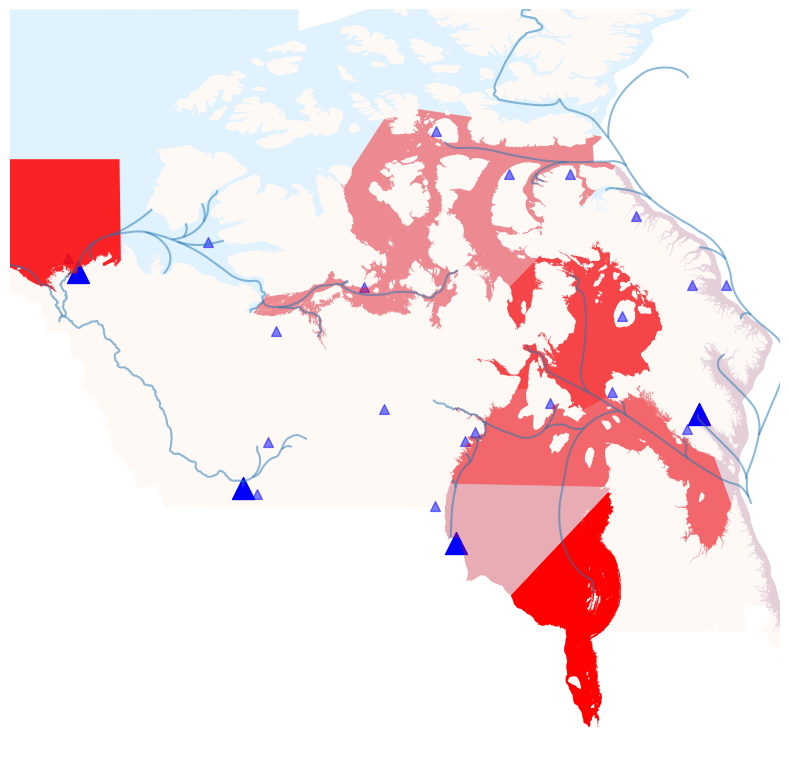

In [4]:
fig, ax3 = plt.subplots(figsize=(8,8))

# Load geometric file for map
ArcticLand = ArcticMap[ArcticMap['Region_EN'].isin(['Arctic'])]
ArcticWater = ArcticMap[ArcticMap['Region_EN'].isin(['Arctic-Water'])]
ArcticLandPlot = ArcticLand.plot(ax=ax3, color="seashell", alpha=.5)  # ax=ax,
ArcticWaterPlot = ArcticWater.plot(ax=ax3, color="lightskyblue", alpha=.25)

# Facilities
coordinates_current = custom_functions.extract_coordinate(current_facility)
coordinate_df = pd.DataFrame(coordinates_current)  # [0]
coordinate_df.columns = ['Latitude','Longitude']
coordinate_gdf = gpd.GeoDataFrame(
    coordinate_df, geometry=gpd.points_from_xy(coordinate_df.Longitude, coordinate_df.Latitude))
coordinate_gdf = coordinate_gdf.set_crs(epsg=4326)
st = plt.scatter(data=coordinate_df,
                 x='Longitude', y='Latitude', marker='^', alpha=1, s=250,
                 c='blue')

# Cache
# station_data
coordinates_cache = custom_functions.extract_coordinate(station_data)
coordinate_df_cache = pd.DataFrame(coordinates_cache)  # [0]
coordinate_df_cache.columns = ['Latitude','Longitude']
coordinate_gdf = gpd.GeoDataFrame(
    coordinate_df_cache, geometry=gpd.points_from_xy(coordinate_df_cache.Longitude, coordinate_df_cache.Latitude))
coordinate_gdf = coordinate_gdf.set_crs(epsg=4326)
cache = plt.scatter(data=coordinate_df_cache,
                 x='Longitude', y='Latitude', marker='^', alpha=0.5, s=50,
                 c='blue')  # ++ why df not gdt in plt.scatter

# Shipping route
Shipping_route_Plot = Shipping_route_shp.plot(ax=ax3,  alpha=.5)

# Sensitivities
sensitivity_dataR = sensitivity_dataR.to_crs(epsg=4326)
sensitivity_dataR['Sensitivity_n'] = (sensitivity_dataR['Sensitivit']-min(sensitivity_dataR['Sensitivit']))/(max(sensitivity_dataR['Sensitivit'])-min(sensitivity_dataR['Sensitivit']))
Sensitivity_Map_Plot = sensitivity_dataR.plot(ax=ax3, color='red', alpha=sensitivity_dataR['Sensitivity_n'])

# fig properties
ax3.grid(False)
ax3.set_xlim([-140, -60])
ax3.set_ylim([50, 80])
plt.axis('off')
#plt.show()
plt.tight_layout()
fig.savefig(f'Outputs/Fig3 gis map.png', transparent=True, bbox_inches='tight')

## Fig4. Spill data map

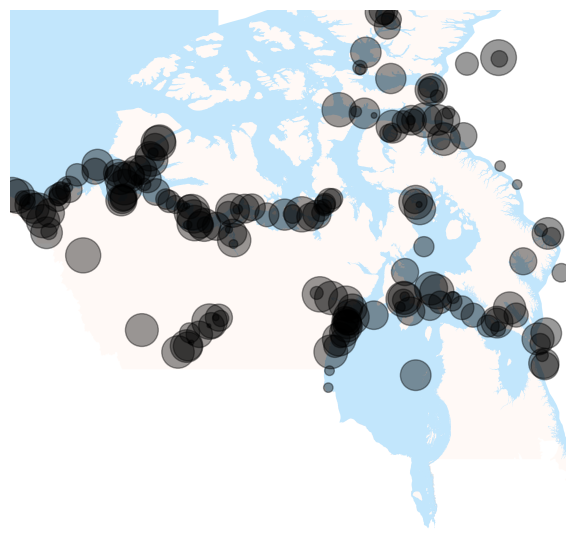

In [5]:
coordinates = custom_functions.extract_coordinate(spill_data_200)
coordinate_df = pd.DataFrame(coordinates)
coordinate_df.columns = ['Latitude', 'Longitude']
coordinate_gdf = gpd.GeoDataFrame(
    coordinate_df, geometry=gpd.points_from_xy(coordinate_df.Longitude, coordinate_df.Latitude))
coordinate_gdf.index = spill_data_200.index
coordinate_gdf['Spill size'] = spill_data_200[['Spill size']].copy()/15
coordinate_gdf = coordinate_gdf.set_crs(epsg=4326)

fig, ax4 = plt.subplots(figsize=(8,7))
ArcticLand = ArcticMap[ArcticMap['Region_EN'].isin(['Arctic'])]
ArcticWater = ArcticMap[ArcticMap['Region_EN'].isin(['Arctic-Water'])]
ArcticLandPlot = ArcticLand.plot(ax=ax4, color="seashell", alpha=.5)  # ax=ax,
ArcticWaterPlot = ArcticWater.plot(ax=ax4, color="lightskyblue", alpha=.5)
plt.scatter(data=coordinate_gdf,
                 x='Longitude', y='Latitude', marker='o', alpha=.4, s='Spill size',
                 c='black')
ax4.set_xlim([-140, -60])
ax4.set_ylim([50, 80])
ax4.axis('off')
fig.savefig(f'Outputs/Fig4a Map of spill data.png', transparent=True, bbox_inches='tight')

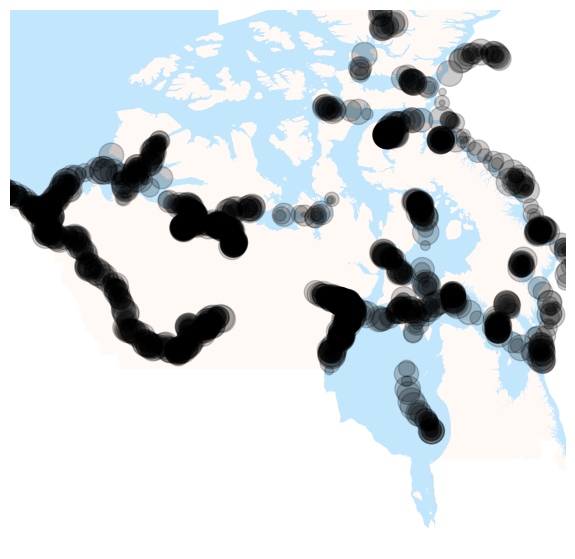

In [6]:

coordinates = custom_functions.extract_coordinate(spill_data_scene2)
coordinate_df = pd.DataFrame(coordinates)
coordinate_df.columns = ['Latitude', 'Longitude']
coordinate_gdf = gpd.GeoDataFrame(
    coordinate_df, geometry=gpd.points_from_xy(coordinate_df.Longitude, coordinate_df.Latitude))
coordinate_gdf.index = spill_data_scene2.index
coordinate_gdf['Spill size'] = spill_data_scene2[['Spill size']].copy()/2
coordinate_gdf = coordinate_gdf.set_crs(epsg=4326)

fig, ax4b = plt.subplots(figsize=(8,7))
ArcticLand = ArcticMap[ArcticMap['Region_EN'].isin(['Arctic'])]
ArcticWater = ArcticMap[ArcticMap['Region_EN'].isin(['Arctic-Water'])]
ArcticLandPlot = ArcticLand.plot(ax=ax4b, color="seashell", alpha=.5)  # ax=ax,
ArcticWaterPlot = ArcticWater.plot(ax=ax4b, color="lightskyblue", alpha=.5)
plt.scatter(data=coordinate_gdf,
                 x='Longitude', y='Latitude', marker='o', alpha=.2, s='Spill size',
                 c='black')
ax4b.set_xlim([-140, -60])
ax4b.set_ylim([50, 80])
ax4b.axis('off')
fig.savefig(f'Outputs/Fig4b Map of spill data.png', transparent=True, bbox_inches='tight')

# Model

## Input parameters

In [7]:
# %% Input parameters of the model
NumberStMax = 2
DistanceMax = 10  # 5

coordinates_spill = custom_functions.extract_coordinate(spill_data_200)
coordinates_st = custom_functions.extract_coordinate(spill_data_200)
num_customers = len(coordinates_spill)
num_facilities = len(coordinates_st)

# ++ convert 10 into km using google map (for reporting, not related to modeling in this code)
coor1 = (63.31720065616187, -90.65327442130385)
coor2 = (61.99735832040513, -92.36804572739923)
custom_functions.compute_distance(coor1, coor2)

pairings = {(c, f): custom_functions.compute_distance(coordinates_spill[c], coordinates_st[f])
            for c in range(num_customers)
            for f in range(num_facilities)
            if custom_functions.compute_distance(tuple(coordinates_spill[c]), tuple(coordinates_st[f])) < DistanceMax}

print("Number of viable pairings: {0}".format(len(pairings.keys())))

# Weights and scaling
# W = [1, 2000, 1]
max_spill_size = max(spill_data_200['Spill size'])
max_sensitivity = max(sensitivity_dataR['Sensitivit'])
max_timeR = pairings[max(pairings, key=pairings.get)]
min_spill_size = min(spill_data_200['Spill size'])
min_sensitivity = min(sensitivity_dataR['Sensitivit'])
min_timeR = pairings[min(pairings, key=pairings.get)]

# x* = (x-x_min)/(x_max - x_min)

#Demand = list(spill_data_200['Resource needed']).copy()

SizeSpill_R = list(spill_data_200['Spill size']).copy()
Sensitivity_R = custom_functions.calculate_sensitivity(coordinates_spill, sensitivity_dataR)
TimeR_R = pairings.copy()  # compute_TimeR +++

SizeSpill = [];
Sensitivity = [];
TimeR = []
SizeSpill = [((SizeSpill_R[i] - min_spill_size) / (max_spill_size - min_spill_size)) for i in range(len(SizeSpill_R))]
Sensitivity = [((Sensitivity_R[i] - min_sensitivity) / (max_sensitivity - min_sensitivity)) for i in
               range(len(Sensitivity_R))]

# TimeR = {((list(TimeR_R.values())[i]-min_timeR)/(max_timeR-min_timeR)) for i in range(len(TimeR_R))}
TimeR_Scaled = [((list(TimeR_R.values())[i] - min_timeR) / (max_timeR - min_timeR)) for i in range(len(TimeR_R))]
keysD = TimeR_R.keys()
TimeR = {}
for i in range(len(keysD)):
    TimeR[list(keysD)[i]] = TimeR_Scaled[i]

Number of viable pairings: 6844


## Optimization Modeling

## Fig5a Tradeoff curve
Predictive Analytics

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-04
m: m1
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7045 rows, 13888 columns and 20732 nonzeros
Model fingerprint: 0xb9359ce4
Variable types: 6844 continuous, 7044 integer (7044 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 310.8444043
Presolve removed 125 rows and 6968 columns
Presolve time: 0.63s
Presolved: 6920 rows, 6920 columns, 20360 nonzeros
Variable types: 0 continuous, 6920 integer (6920 binary)

Root relaxation: objective 5.199648e+02, 7723 iterations, 0.31 seconds (0.12 work units)

    Nodes    |    Current Node    |     Objective Bounds

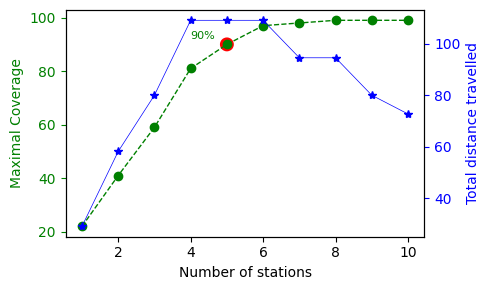

<Figure size 640x480 with 0 Axes>

In [8]:
# Tradeoff curve for number of stations
# ----------------------------------------------------------------------------------------------------------------------
NumberStMax_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
W1 = [[0.1, 0.2, 0.7], [0.8, 0.1, 0.1]]  # from model configuration table
Tradeoff_output = []
for i in range(len(NumberStMax_list)):
    Wi = W1[1]
    NumberStMax = NumberStMax_list[i]
    m = 'm1'  # m2
    model, cover, select, amount, mvars, names, values, \
        cover_1s, select_1s, amountSt_groupby, coverage_percentage, \
        ResponseTimeT, assignment3, spill_df, station_df, \
        sol_y, assignment, assignment2, assignment_name = model_PAMIP.solve(Wi, coordinates_st, coordinates_spill,
                                                                            pairings, SizeSpill, Sensitivity, TimeR,
                                                                            NumberStMax, m, spill_data_200)

    Tradeoff_output.append([NumberStMax, coverage_percentage, int(ResponseTimeT * 80) / 11])

Tradeoff_Output_df = pd.DataFrame(Tradeoff_output)
Tradeoff_Output_df.columns = ['NumberStMax', 'Coverage %', 'Response time (in hours)']
Tradeoff_Output_df.to_csv('Outputs/Fig5a Tradeoff_Output_df.csv')

NumberStMax_data = pd.read_csv('Outputs/Fig5a Tradeoff_Output_df.csv').copy()
selected = 5
data_visualization.draw_tradeoff_plot(NumberStMax_data, selected)


## Table 5 Model configuration

In [9]:
# Comparing models with different weight vectors
import random

values = [.1, .2, .3, .4, .5, .6, .7, .8]
Wd = []
for i in range(1000):
    w1 = random.choice(values);
    w2 = random.choice(values);
    w3 = random.choice(values)
    if w1 + w2 + w3 == 1.0:
        Wd.append([w1, w2, w3])
# drop duplication values from list W
W_Set = set(tuple(element) for element in Wd)
W0 = [list(t) for t in set(tuple(element) for element in W_Set)]

W = [W0[i] for i in range(10)]

m = 'm2'
model_output = []
# Draw Network Diagram
for i in range(5):
    Wi = W[i]
    model, cover, select, amount, mvars, names, values, \
        cover_1s, select_1s, amountSt_groupby, coverage_percentage, \
        ResponseTimeT, assignment3, spill_df, station_df, \
        sol_y, assignment, assignment2, assignment_name = model_PAMIP.solve(Wi, coordinates_st, coordinates_spill,
                                                                            pairings, SizeSpill, Sensitivity, TimeR,
                                                                            NumberStMax, m, spill_data_200)

    print(f'coverage_percentage: {coverage_percentage}, i: {i}, W: {Wi}')

    model_output.append([Wi, model.ObjVal, coverage_percentage, int(ResponseTimeT * 80) / 11])
    print('-------------------------------------------------------------')
Model_Output = pd.DataFrame(model_output)
Model_Output.columns = ['Weights', 'Objective Value', 'Coverage %', 'Response time (in hours)']
Model_Output.to_csv('Outputs/Table5 Model_Output.csv')

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7045 rows, 13888 columns and 20732 nonzeros
Model fingerprint: 0x92c68884
Variable types: 6844 continuous, 7044 integer (7044 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 112.9800163
Presolve removed 172 rows and 7016 columns
Presolve time: 0.07s
Presolved: 6873 rows, 6872 columns, 20216 nonzeros
Variable types: 0 continuous, 6872 integer (6872 binary)
Found heuristic solution: objective 117.2490937

Root relaxation: objective 1.808593e+02, 4147 iterations, 0.26 seconds (0.10 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth

## Fig 6a. Network Diagram (Data Scene 1)

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7045 rows, 13888 columns and 20732 nonzeros
Model fingerprint: 0x92c68884
Variable types: 6844 continuous, 7044 integer (7044 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 112.9800163
Presolve removed 172 rows and 7016 columns
Presolve time: 0.09s
Presolved: 6873 rows, 6872 columns, 20216 nonzeros
Variable types: 0 continuous, 6872 integer (6872 binary)
Found heuristic solution: objective 117.2490937

Root relaxation: objective 1.808593e+02, 4147 iterations, 0.21 seconds (0.10 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth

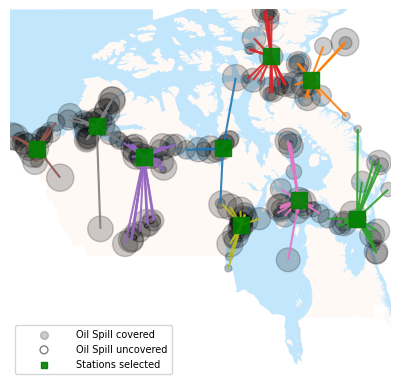

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7045 rows, 13888 columns and 20732 nonzeros
Model fingerprint: 0x9ce35e29
Variable types: 6844 continuous, 7044 integer (7044 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-04, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 144.9354570
Presolve removed 828 rows and 7670 columns
Presolve time: 0.06s
Presolved: 6217 rows, 6218 columns, 18254 nonzeros
Variable types: 0 continuous, 6218 integer (6218 binary)
Found heuristic solution: objective 153.9840519

Root relaxation: objective 2.520014e+02, 3085 iterations, 0.12 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth

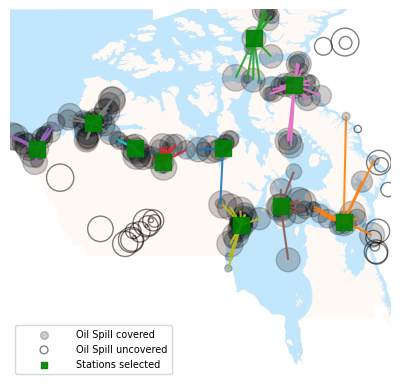

In [10]:
# Examine model results
# Sensitivity analysis
NumberStMax = 10
W1 = [[0.6, 0.1, 0.3], [0.1, 0.2, 0.7]]  # from model configuration table
for i in range(2):
    Wi = W1[i]
    m = 'm2'  # m2
    model, cover, select, amount, mvars, names, values, \
        cover_1s, select_1s, amountSt_groupby, coverage_percentage, \
        ResponseTimeT, assignment3, spill_df, station_df, \
        sol_y, assignment, assignment2, assignment_name = model_PAMIP.solve(Wi, coordinates_st, coordinates_spill,
                                                                            pairings, SizeSpill, Sensitivity, TimeR,
                                                                            NumberStMax, m, spill_data_200)

    model_analysis.draw_network_diagram(DistanceMax, NumberStMax, spill_df, station_df, ResponseTimeT,
                                        coverage_percentage,
                                        assignment3, cover_1s, select_1s, amountSt_groupby, m, Wi, ArcticLand, ArcticWater)

## Fig6b

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7045 rows, 13888 columns and 20732 nonzeros
Model fingerprint: 0xbb5c3e57
Variable types: 6844 continuous, 7044 integer (7044 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 65.9433194
Presolve removed 172 rows and 7016 columns
Presolve time: 0.09s
Presolved: 6873 rows, 6872 columns, 20216 nonzeros
Variable types: 0 continuous, 6872 integer (6872 binary)
Found heuristic solution: objective 68.4010157

Root relaxation: objective 1.633502e+02, 7348 iterations, 0.89 seconds (0.19 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth I

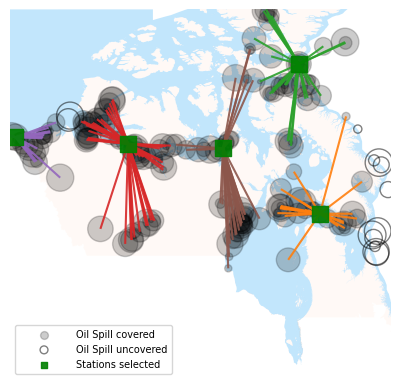

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7045 rows, 13888 columns and 20732 nonzeros
Model fingerprint: 0x3b79883d
Variable types: 6844 continuous, 7044 integer (7044 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-04, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 85.4099661
Presolve removed 828 rows and 7670 columns
Presolve time: 0.11s
Presolved: 6217 rows, 6218 columns, 18254 nonzeros
Variable types: 0 continuous, 6218 integer (6218 binary)
Found heuristic solution: objective 90.0251041

Root relaxation: objective 2.242739e+02, 6353 iterations, 0.58 seconds (0.16 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth I

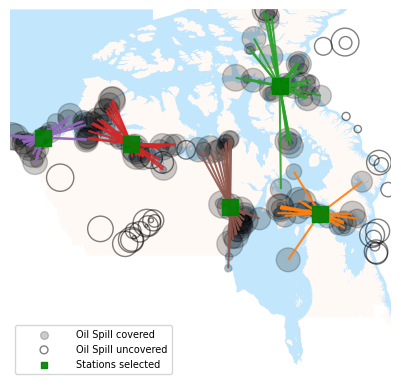

In [11]:
# Comparing models with different weight vectors
NumberStMax = 5
values = [.1, .2, .3, .4, .5, .6, .7, .8]
Wd = []
for i in range(1000):
    w1 = random.choice(values);
    w2 = random.choice(values);
    w3 = random.choice(values)
    if w1 + w2 + w3 == 1.0:
        Wd.append([w1, w2, w3])
# drop duplication values from list W
W_Set = set(tuple(element) for element in Wd)
W0 = [list(t) for t in set(tuple(element) for element in W_Set)]

W = [W0[i] for i in range(10)]

m = 'm2'
model_output = []
# Draw Network Diagram
for i in range(5):
    Wi = W[i]
    model, cover, select, amount, mvars, names, values, \
        cover_1s, select_1s, amountSt_groupby, coverage_percentage, \
        ResponseTimeT, assignment3, spill_df, station_df, \
        sol_y, assignment, assignment2, assignment_name = model_PAMIP.solve(Wi, coordinates_st, coordinates_spill,
                                                                            pairings, SizeSpill, Sensitivity, TimeR,
                                                                            NumberStMax, m, spill_data_200)

    print(f'coverage_percentage: {coverage_percentage}, i: {i}, W: {Wi}')
    model_output.append([Wi, model.ObjVal, coverage_percentage, int(ResponseTimeT * 80) / 11])
    print('-------------------------------------------------------------')
Model_Output = pd.DataFrame(model_output)
Model_Output.columns = ['Weights', 'Objective Value', 'Coverage %', 'Response time (in hours)']
Model_Output.to_csv('Outputs/Model_Output.csv')

# Examine model results
# Sensitivity analysis
W1 = [[0.8, 0.1, 0.1], [0.1, 0.2, 0.7]]  # from model configuration table
for i in range(2):
    Wi = W1[i]
    m = 'm2'  # m2
    model, cover, select, amount, mvars, names, values, \
        cover_1s, select_1s, amountSt_groupby, coverage_percentage, \
        ResponseTimeT, assignment3, spill_df, station_df, \
        sol_y, assignment, assignment2, assignment_name = model_PAMIP.solve(Wi, coordinates_st, coordinates_spill,
                                                                            pairings, SizeSpill, Sensitivity, TimeR,
                                                                            NumberStMax, m, spill_data_200)

    model_analysis.draw_network_diagram(DistanceMax, NumberStMax, spill_df, station_df, ResponseTimeT,
                                        coverage_percentage,
                                        assignment3, cover_1s, select_1s, amountSt_groupby, m, Wi, ArcticLand, ArcticWater)

# Data Scene 2

## Fig5b Kmeans clustering

C:\Users\tanmo\OneDrive - Dalhousie University\PhD Tanmoy Das\Implementation of Deterministic Resource Optimization TD 01.2023\deterministic_env\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



First cluster center: [ 73.18462029 -85.27786021]
Weights for first 10 clusters: [87, 75, 40, 13, 57, 43, 45, 13, 24, 48]


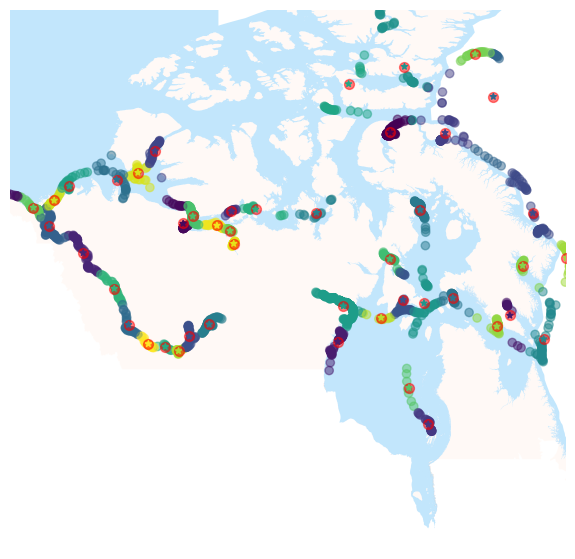

In [12]:
# %% Input parameters of the model
NumberStMax = 5
DistanceMax = 10  # 5
num_customers = len(coordinates_spill)
num_facilities = len(coordinates_st)
spill_size = spill_data_scene2[['Spill size']]

coordinates_spill_scene2 = custom_functions.extract_coordinate(spill_data_scene2)
# Cluster them into 50 cluster
num_clusters = 50

kmeans = MiniBatchKMeans(n_clusters=num_clusters, init_size=3 * num_clusters,
                         ).fit(coordinates_spill_scene2)
memberships = list(kmeans.labels_)
centroids = list(kmeans.cluster_centers_)  # Center point for each cluster
weights = list(np.histogram(memberships, bins=num_clusters)[0])  # Number of customers in each cluster
print('First cluster center:', centroids[0])
print('Weights for first 10 clusters:', weights[:10])

# Draw
icon_size_list = []
# Draw the oil spills
for point_spill in range(0, len(coordinates_spill_scene2)):
    icon_size = int((spill_size.iloc[point_spill, 0] / spill_size.max()) * 20)
    icon_size_list.append(icon_size)

size_10times = [item * 10 for item in icon_size_list]
coordinates_spill_df = pd.DataFrame(coordinates_spill_scene2)
coordinates_spill_df.columns = ['Latitude', 'Longitude']

centroids_df = pd.DataFrame(centroids)
centroids_df.columns = ['Latitude', 'Longitude']

data_visualization.draw_cluster(coordinates_spill_df, centroids_df, memberships, ArcticLand, ArcticWater)

In [13]:
# Input parameters
coordinates_spill_cluster = kmeans.cluster_centers_.tolist()
pairings = custom_functions.compute_pairing(coordinates_spill_cluster, coordinates_st, DistanceMax)
Size_DS1 = list(spill_data_scene2['Spill size']).copy()

cluster_index = {}
for j in range(len(centroids)):
    cluster_index[j] = [i for i, x in enumerate(memberships) if x == j]
SizeSpill_Rc = [sum([e for i, e in enumerate(Size_DS1) if i in cluster_index[ii]]) for ii in range(len(cluster_index))]
Sensitivity_Rc = custom_functions.calculate_sensitivity(coordinates_spill_cluster, sensitivity_dataR)
TimeRc = pairings.copy()

max_spill_size = max(SizeSpill_Rc)
min_spill_size = min(SizeSpill_Rc)

max_sensitivity = max(Sensitivity_Rc)
min_sensitivity = min(Sensitivity_Rc)

max_timeR = pairings[max(pairings, key=pairings.get)]
min_timeR = pairings[min(pairings, key=pairings.get)]

SizeSpill = [];
Sensitivity = [];
TimeR = [];
SizeSpill = [((SizeSpill_Rc[i] - min_spill_size) / (max_spill_size - min_spill_size)) for i in range(len(SizeSpill_Rc))]
Sensitivity = [((Sensitivity_Rc[i] - min_sensitivity) / (max_sensitivity - min_sensitivity)) for i in
               range(len(Sensitivity_Rc))]

# TimeR = {((list(TimeR_R.values())[i]-min_timeR)/(max_timeR-min_timeR)) for i in range(len(TimeR_R))}
TimeR_Scaled = [((list(TimeRc.values())[i] - min_timeR) / (max_timeR - min_timeR)) for i in range(len(TimeRc))]
keysD = TimeRc.keys()
TimeR = {}
for i in range(len(keysD)):
    TimeR[list(keysD)[i]] = TimeR_Scaled[i]

## Fig7 Network Diagram for data scene 2

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1633 rows, 3364 columns and 4946 nonzeros
Model fingerprint: 0x2aad51c6
Variable types: 1582 continuous, 1782 integer (1782 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 0.8316521
Presolve removed 1145 rows and 2716 columns
Presolve time: 0.02s
Presolved: 488 rows, 648 columns, 1556 nonzeros
Variable types: 0 continuous, 648 integer (647 binary)
Found heuristic solution: objective 1.0601163

Root relaxation: objective 2.924985e+00, 310 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | I

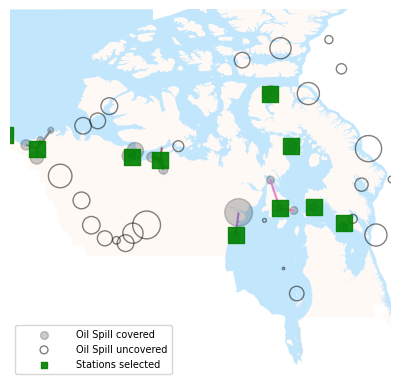

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1633 rows, 3364 columns and 4946 nonzeros
Model fingerprint: 0x9c4683d1
Variable types: 1582 continuous, 1782 integer (1782 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-04, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 0.3406055
Presolve removed 1534 rows and 3221 columns
Presolve time: 0.02s
Presolved: 99 rows, 143 columns, 317 nonzeros
Found heuristic solution: objective 1.4936694
Variable types: 0 continuous, 143 integer (143 binary)
Found heuristic solution: objective 1.6457332

Root relaxation: objective 1.793407e+00, 74 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |    

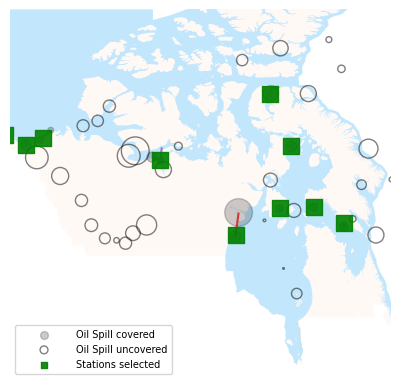

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1633 rows, 3364 columns and 4946 nonzeros
Model fingerprint: 0xdc364994
Variable types: 1582 continuous, 1782 integer (1782 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-04, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 2.5000747
Presolve removed 380 rows and 1958 columns
Presolve time: 0.02s
Presolved: 1253 rows, 1406 columns, 3818 nonzeros
Variable types: 0 continuous, 1406 integer (1406 binary)
Found heuristic solution: objective 2.7980470

Root relaxation: objective 4.969606e+00, 700 iterations, 0.03 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf 

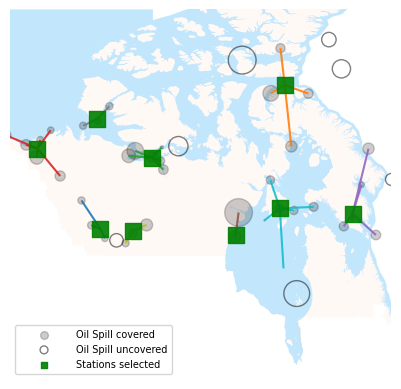

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1633 rows, 3364 columns and 4946 nonzeros
Model fingerprint: 0xbb4d26bc
Variable types: 1582 continuous, 1782 integer (1782 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 4e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 1.1005805
Presolve removed 1117 rows and 2718 columns
Presolve time: 0.02s
Presolved: 516 rows, 646 columns, 1624 nonzeros
Variable types: 0 continuous, 646 integer (646 binary)
Found heuristic solution: objective 1.5576830

Root relaxation: objective 4.322181e+00, 288 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | I

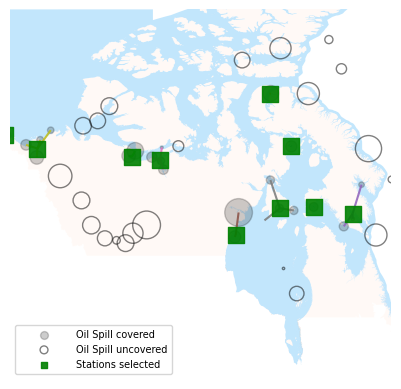

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1633 rows, 3364 columns and 4946 nonzeros
Model fingerprint: 0x8ef2d5e4
Variable types: 1582 continuous, 1782 integer (1782 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-05, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 0.3846419
Presolve removed 1491 rows and 3160 columns
Presolve time: 0.02s
Presolved: 142 rows, 204 columns, 462 nonzeros
Found heuristic solution: objective 1.2728967
Variable types: 0 continuous, 204 integer (204 binary)
Found heuristic solution: objective 1.4468650

Root relaxation: objective 1.837952e+00, 123 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |  

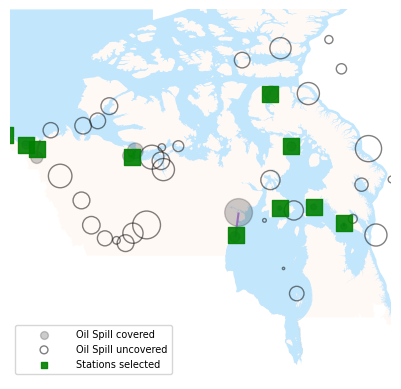

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1633 rows, 3364 columns and 4946 nonzeros
Model fingerprint: 0xf19dbbfd
Variable types: 1582 continuous, 1782 integer (1782 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 9.1458755
Presolve removed 186 rows and 1766 columns
Presolve time: 0.02s
Presolved: 1447 rows, 1598 columns, 4394 nonzeros
Variable types: 0 continuous, 1598 integer (1598 binary)
Found heuristic solution: objective 9.4471768

Root relaxation: objective 1.384226e+01, 894 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf 

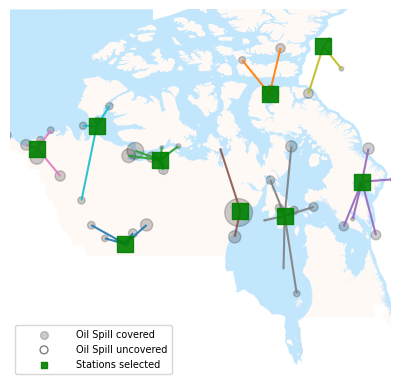

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1633 rows, 3364 columns and 4946 nonzeros
Model fingerprint: 0x0bda0ce9
Variable types: 1582 continuous, 1782 integer (1782 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 6.2913468
Presolve removed 182 rows and 1762 columns
Presolve time: 0.02s
Presolved: 1451 rows, 1602 columns, 4406 nonzeros
Variable types: 0 continuous, 1602 integer (1602 binary)
Found heuristic solution: objective 6.5898192

Root relaxation: objective 9.953644e+00, 848 iterations, 0.03 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf 

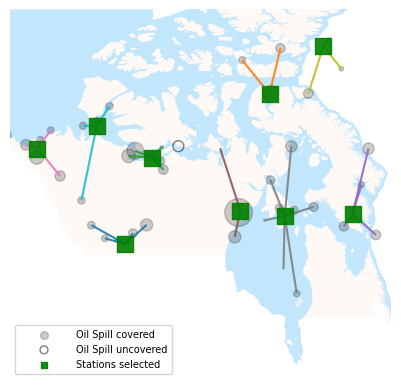

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1633 rows, 3364 columns and 4946 nonzeros
Model fingerprint: 0xfe6ea3a6
Variable types: 1582 continuous, 1782 integer (1782 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-05, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 4.6491131
Presolve removed 524 rows and 2099 columns
Presolve time: 0.01s
Presolved: 1109 rows, 1265 columns, 3395 nonzeros
Variable types: 0 continuous, 1265 integer (1265 binary)
Found heuristic solution: objective 5.0826553

Root relaxation: objective 8.405966e+00, 538 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf 

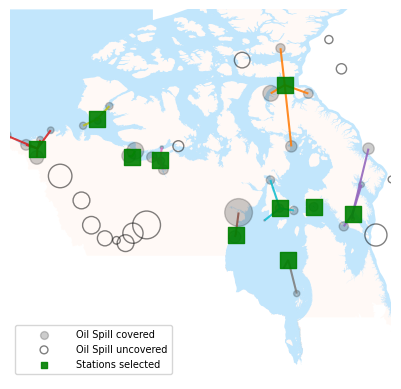

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1633 rows, 3364 columns and 4946 nonzeros
Model fingerprint: 0x2f08aa00
Variable types: 1582 continuous, 1782 integer (1782 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 1.3633573
Presolve removed 818 rows and 2388 columns
Presolve time: 0.02s
Presolved: 815 rows, 976 columns, 2530 nonzeros
Variable types: 0 continuous, 976 integer (975 binary)
Found heuristic solution: objective 1.5054000

Root relaxation: objective 3.657158e+00, 471 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | In

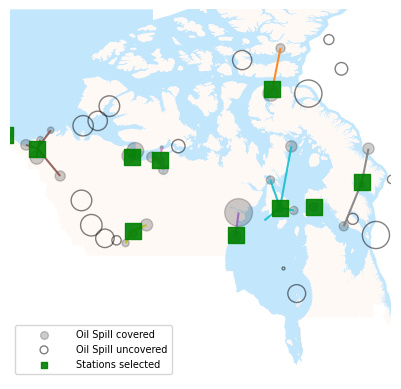

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1633 rows, 3364 columns and 4946 nonzeros
Model fingerprint: 0xeab7e787
Variable types: 1582 continuous, 1782 integer (1782 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-06, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 0.4570986
Presolve removed 1465 rows and 3131 columns
Presolve time: 0.02s
Presolved: 168 rows, 233 columns, 536 nonzeros
Found heuristic solution: objective 1.6472684
Variable types: 0 continuous, 233 integer (233 binary)

Root relaxation: objective 2.186747e+00, 128 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | In

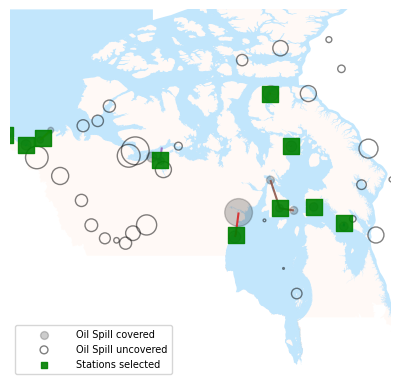

In [14]:
m = 'm2'
NumberStMax = 10

# Solve the model
W1 = W  #[[0.1, 0.2, 0.7], [0.2, 0.7, 0.1]] # from model configuration table
for i in range(10):
    Wi = W1[i]
    m = 'm2'  # m2
    model, cover, select, amount, mvars, names, values, \
        cover_1s, select_1s, amountSt_groupby, coverage_percentage, \
        ResponseTimeT, assignment3, spill_df, station_df, \
        sol_y, assignment, assignment2, assignment_name = model_PAMIP.solve(Wi, coordinates_st, coordinates_spill_cluster,
                                                                            pairings, SizeSpill, Sensitivity, TimeR,
                                                                            NumberStMax, m, spill_data_scene2)

    model_analysis.draw_network_diagram(DistanceMax, NumberStMax, spill_df, station_df, ResponseTimeT,
                                        coverage_percentage,
                                        assignment3, cover_1s, select_1s, amountSt_groupby, m, Wi, ArcticLand, ArcticWater)


## Fig7b

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1633 rows, 3364 columns and 4946 nonzeros
Model fingerprint: 0xe2748484
Variable types: 1582 continuous, 1782 integer (1782 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 0.1874289
Presolve removed 1201 rows and 2814 columns
Presolve time: 0.02s
Presolved: 432 rows, 550 columns, 1360 nonzeros
Found heuristic solution: objective 0.9154055
Variable types: 0 continuous, 550 integer (550 binary)
Found heuristic solution: objective 1.0155796

Root relaxation: objective 2.090409e+00, 360 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      | 

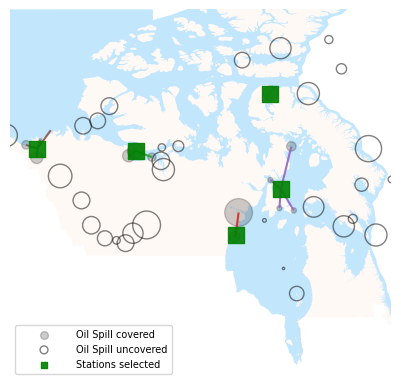

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1633 rows, 3364 columns and 4946 nonzeros
Model fingerprint: 0x9274900d
Variable types: 1582 continuous, 1782 integer (1782 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-04, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 0.0601409
Presolve removed 1534 rows and 3226 columns
Presolve time: 0.01s
Presolved: 99 rows, 138 columns, 312 nonzeros
Found heuristic solution: objective 0.9251680
Variable types: 0 continuous, 138 integer (138 binary)
Found heuristic solution: objective 0.9331133

Root relaxation: objective 9.778047e-01, 83 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |    

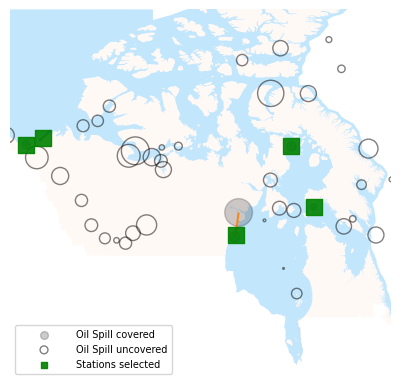

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1633 rows, 3364 columns and 4946 nonzeros
Model fingerprint: 0xfb1db6af
Variable types: 1582 continuous, 1782 integer (1782 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-04, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 1.2767653
Presolve removed 380 rows and 1958 columns
Presolve time: 0.02s
Presolved: 1253 rows, 1406 columns, 3818 nonzeros
Variable types: 0 continuous, 1406 integer (1406 binary)
Found heuristic solution: objective 1.3998416

Root relaxation: objective 4.235669e+00, 1017 iterations, 0.03 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf

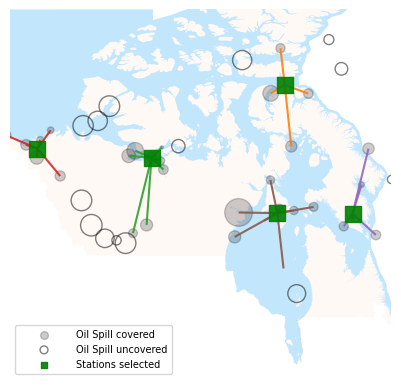

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1633 rows, 3364 columns and 4946 nonzeros
Model fingerprint: 0x2e06af83
Variable types: 1582 continuous, 1782 integer (1782 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 4e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 0.3106614
Presolve removed 1117 rows and 2718 columns
Presolve time: 0.03s
Presolved: 516 rows, 646 columns, 1624 nonzeros
Variable types: 0 continuous, 646 integer (646 binary)
Found heuristic solution: objective 0.6361293

Root relaxation: objective 3.000222e+00, 404 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | I

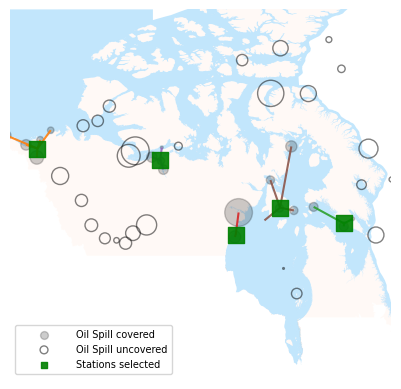

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1633 rows, 3364 columns and 4946 nonzeros
Model fingerprint: 0x55b381e9
Variable types: 1582 continuous, 1782 integer (1782 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-05, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 0.0835744
Presolve removed 1491 rows and 3165 columns
Presolve time: 0.01s
Presolved: 142 rows, 199 columns, 457 nonzeros
Found heuristic solution: objective 0.8132200
Variable types: 0 continuous, 199 integer (199 binary)
Found heuristic solution: objective 0.8831827

Root relaxation: objective 1.225426e+00, 123 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |  

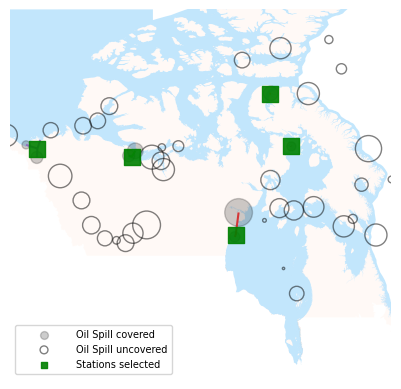

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1633 rows, 3364 columns and 4946 nonzeros
Model fingerprint: 0x8c2f7785
Variable types: 1582 continuous, 1782 integer (1782 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 5.0580245
Presolve removed 186 rows and 1766 columns
Presolve time: 0.02s
Presolved: 1447 rows, 1598 columns, 4394 nonzeros
Variable types: 0 continuous, 1598 integer (1598 binary)
Found heuristic solution: objective 5.1811009

Root relaxation: objective 1.276075e+01, 1492 iterations, 0.05 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf

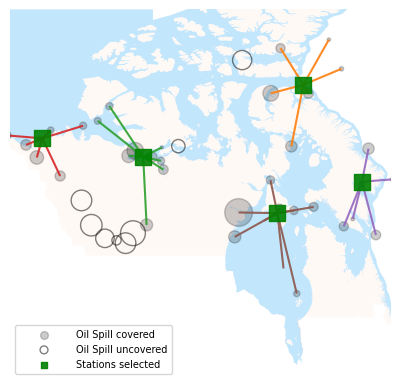

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1633 rows, 3364 columns and 4946 nonzeros
Model fingerprint: 0xf3b01677
Variable types: 1582 continuous, 1782 integer (1782 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 3.4350165
Presolve removed 182 rows and 1762 columns
Presolve time: 0.02s
Presolved: 1451 rows, 1602 columns, 4406 nonzeros
Variable types: 0 continuous, 1602 integer (1602 binary)
Found heuristic solution: objective 3.5580929

Root relaxation: objective 9.035758e+00, 1346 iterations, 0.04 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf

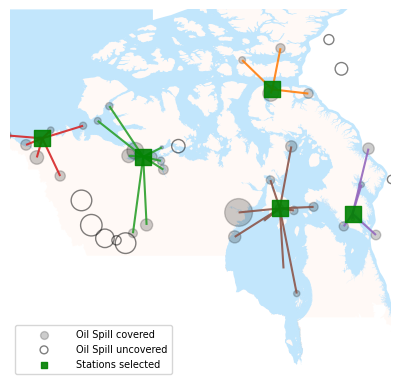

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1633 rows, 3364 columns and 4946 nonzeros
Model fingerprint: 0x665b6b00
Variable types: 1582 continuous, 1782 integer (1782 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-05, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 2.4099470
Presolve removed 524 rows and 2099 columns
Presolve time: 0.01s
Presolved: 1109 rows, 1265 columns, 3395 nonzeros
Variable types: 0 continuous, 1265 integer (1265 binary)
Found heuristic solution: objective 2.5587951

Root relaxation: objective 7.357897e+00, 865 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf 

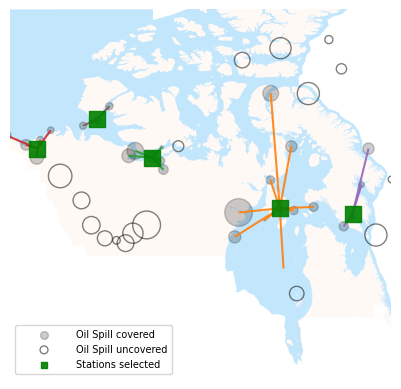

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1633 rows, 3364 columns and 4946 nonzeros
Model fingerprint: 0x9cdc1158
Variable types: 1582 continuous, 1782 integer (1782 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 0.4480215
Presolve removed 818 rows and 2388 columns
Presolve time: 0.01s
Presolved: 815 rows, 976 columns, 2530 nonzeros
Variable types: 0 continuous, 976 integer (975 binary)
Found heuristic solution: objective 0.5595553

Root relaxation: objective 2.862374e+00, 629 iterations, 0.02 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | In

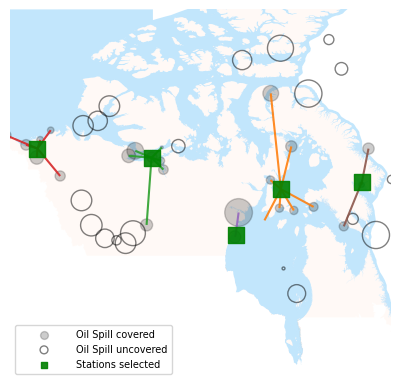

m: m2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1633 rows, 3364 columns and 4946 nonzeros
Model fingerprint: 0xce346049
Variable types: 1582 continuous, 1782 integer (1782 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-06, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 0.0874160
Presolve removed 1465 rows and 3136 columns
Presolve time: 0.01s
Presolved: 168 rows, 228 columns, 531 nonzeros
Found heuristic solution: objective 0.9601647
Variable types: 0 continuous, 228 integer (228 binary)
Found heuristic solution: objective 0.9837613

Root relaxation: objective 1.239571e+00, 150 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |  

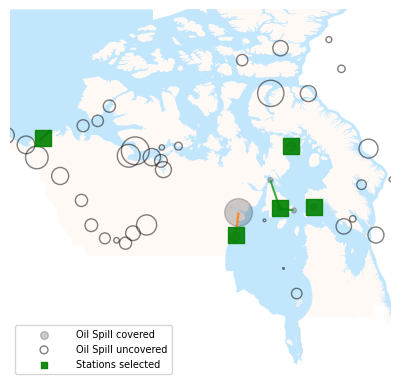

In [15]:
m = 'm2'
NumberStMax = 5

# Solve the model
W1 = W  #[[0.1, 0.2, 0.7], [0.2, 0.7, 0.1]] # from model configuration table
for i in range(10):
    Wi = W1[i]
    m = 'm2'  # m2
    model, cover, select, amount, mvars, names, values, \
        cover_1s, select_1s, amountSt_groupby, coverage_percentage, \
        ResponseTimeT, assignment3, spill_df, station_df, \
        sol_y, assignment, assignment2, assignment_name = model_PAMIP.solve(Wi, coordinates_st, coordinates_spill_cluster,
                                                                            pairings, SizeSpill, Sensitivity, TimeR,
                                                                            NumberStMax, m, spill_data_scene2)

    model_analysis.draw_network_diagram(DistanceMax, NumberStMax, spill_df, station_df, ResponseTimeT,
                                        coverage_percentage,
                                        assignment3, cover_1s, select_1s, amountSt_groupby, m, Wi, ArcticLand, ArcticWater)
